# Dataset analysis

## Common premable

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb, ShaderDb
from toyDb.utils.Directory import getToyDbRootDir

import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch

ExperimentDb.init_from_default_db()

## experiments.db & ShaderDb analysis

In [2]:
shaderDB = ShaderDb.ShaderDB(os.path.join(getToyDbRootDir(), "shaders"))
shaderDB.scan_local()
shaderDB.load_all()

all_shaders = set(shaderDB.offlineShaders.keys())
imageonly_shaders = shaderDB.filter_attribute(["is_imageonly"])

# all environments available in database
all_environments = ExperimentDb.Environment.select()

# shaders that have at least 1 non-error measurement
measurable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
    ).distinct()
])

# shaders that have measurements in all working environments
all_measurable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0
    )
])

measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
      ExperimentDb.ImageOnlyExperiment.trace.is_null(False)
    ).distinct()
])

all_measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0,
      pw.fn.SUM(ExperimentDb.ImageOnlyExperiment.trace.is_null(True)) == 0
    )
])

all_measurable_and_traceable_canonical_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
      ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
      ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
      ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT
    ).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0,
      pw.fn.SUM(ExperimentDb.ImageOnlyExperiment.trace.is_null(True)) == 0
    )
])

In [3]:
print(f"Number of shaders in Shadertoy Offline Database: {len(all_shaders)}")
print(f"Number of ImageOnly shaders: {len(imageonly_shaders)}")
print(f"Number of environments: {len(all_environments)}")

print(f"Number of measurable shaders: {len(measurable_shaders)}")
print(f"Number of all measurable shaders: {len(all_measurable_shaders)}")
print(f"Number of measurable and traceable shaders: {len(measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable shaders: {len(all_measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable canonical experimented shaders: {len(all_measurable_and_traceable_canonical_shaders)}")


Number of shaders in Shadertoy Offline Database: 27911
Number of ImageOnly shaders: 20669
Number of environments: 3
Number of measurable shaders: 14280
Number of all measurable shaders: 14228
Number of measurable and traceable shaders: 14261
Number of all measurable and traceable shaders: 11529
Number of all measurable and traceable canonical experimented shaders: 11530


In [4]:
measurable_shaders - measurable_and_traceable_shaders

{'4lscW2',
 '4syXRR',
 '7lXcW8',
 'DdS3Wh',
 'MllBR2',
 'Nd33Dr',
 'NtjcRV',
 'Wd3fDH',
 'WdKcWd',
 'XdSBDd',
 'XdyBWD',
 'Xl2cRR',
 'ddlXD4',
 'fdy3DW',
 'mdyGWG',
 'sdcGWB',
 'tsVcWt',
 'wdcSzn',
 'wltGWs'}

## Distribution analysis

There are several impact factors on training, including
- distribution of time
- distribution of trace count
- distribution of number of SPIR-V instructions
- distribution of number of tokens in tokenized shaders

The analysis is done for 3060 environment.

In [5]:
environment_selected = all_environments[0]
print(f"Environment selected: {environment_selected.node} - {environment_selected.cpu} - {environment_selected.gpu} - {environment_selected.gpu_driver}")

Environment selected: libreliu-GCL-Arch -  Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz - NVIDIA GeForce RTX 3060 - NVIDIA 535.113.01


In [6]:
# Select experiments where shaderIDs match the shaderID provided, and
# return the first if have multiple record
shader_to_experiment = {}
query = ExperimentDb.ImageOnlyExperiment.select(
      ExperimentDb.ImageOnlyExperiment
    ).where(
      # Canonical condition
      ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
      ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
      ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
      ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT,
      # Inside all_measurable_and_traceable_canonical_shaders
      ExperimentDb.ImageOnlyExperiment.environment == environment_selected,
      ExperimentDb.ImageOnlyExperiment.errors == 0,
      ExperimentDb.ImageOnlyExperiment.augmentation == 20000
    ).order_by(
      ExperimentDb.ImageOnlyExperiment.shader_shadertoy_id
    )

# To debug the SQL command use this
# print(query)
  
for expr in query:
  shader_id = expr.shader_shadertoy_id
  if shader_id not in all_measurable_and_traceable_canonical_shaders:
    continue

  if shader_id not in shader_to_experiment:
    shader_to_experiment[shader_id] = expr

print(f"Number of experiment selected: {len(shader_to_experiment)}")


Number of experiment selected: 11174


In [7]:
timeResults = np.ndarray((len(shader_to_experiment), ExperimentDb.CANONICAL_NUM_TRIALS), dtype=np.float64)
shaderIds = []
for idx, (shaderId, expr) in enumerate(shader_to_experiment.items()):
    if expr.results == "":
        raise Exception(f"[{idx}] id={expr.id} doesn't have results")
    timeResults[idx, :] = json.loads(expr.results)
    shaderIds.append(shaderId)

shaderIds = np.array(shaderIds)
timeMean = np.mean(timeResults, axis=1)
timeStdev = np.std(timeResults, axis=1)

indices = np.argsort(timeMean)
timeMean = timeMean[indices]
timeStdev = timeStdev[indices]
shaderIds = shaderIds[indices]

### Distribution of time measured

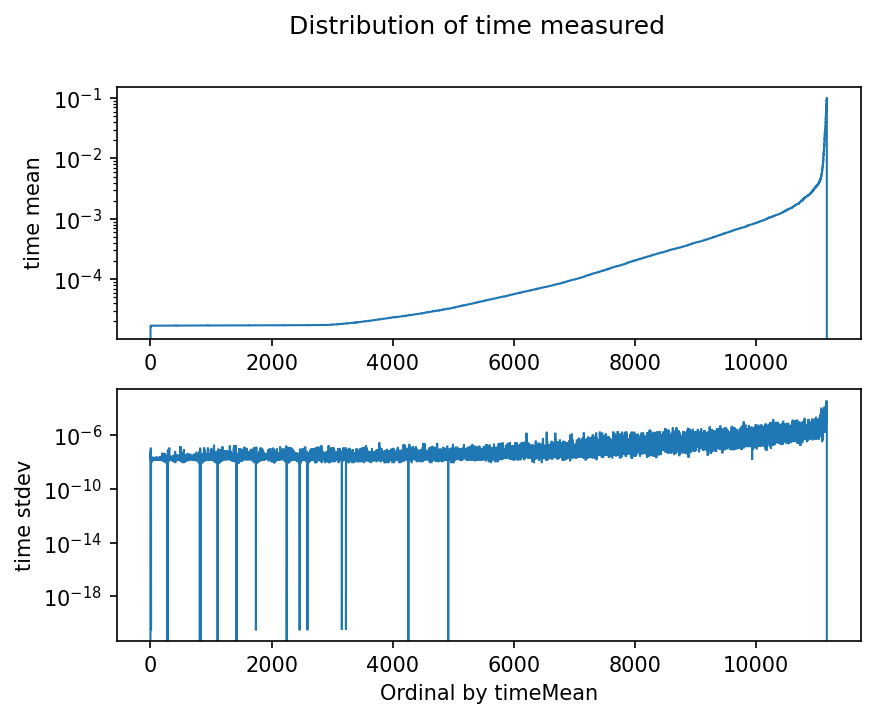

In [8]:
plt.rcParams['figure.dpi'] = 150
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f"Distribution of time measured")

ax1.stairs(timeMean)

# ax1.set_xlabel('Ordinal by timeMean')
ax1.set_ylabel('time mean')
ax1.set_yscale('log')

# ax2.bar([i for i in range(0, len(timeStdev))], timeStdev)
ax2.stairs(timeStdev)

ax2.set_xlabel('Ordinal by timeMean')
ax2.set_ylabel('time stdev')
ax2.set_yscale('log')

plt.show()

Statistics by slot used in metrics.

分为如下几组：
- `time >= 1e-1 sec` (也就是 `fps <= 10`)
- `1e-2 <= time < 1e-1` (也就是 `10 <= fps <= 100`)
- `1e-3 <= time < 1e-2` (也就是 `100 <= fps <= 1000`)
- `1e-4 <= time < 1e-3` (也就是 `1000 <= fps <= 10000`)
- `time < 1e-4` (也就是 `10000 < fps`)

[1.603584e-05, 0.0001, 0.001, 0.01, 0.09992843264]


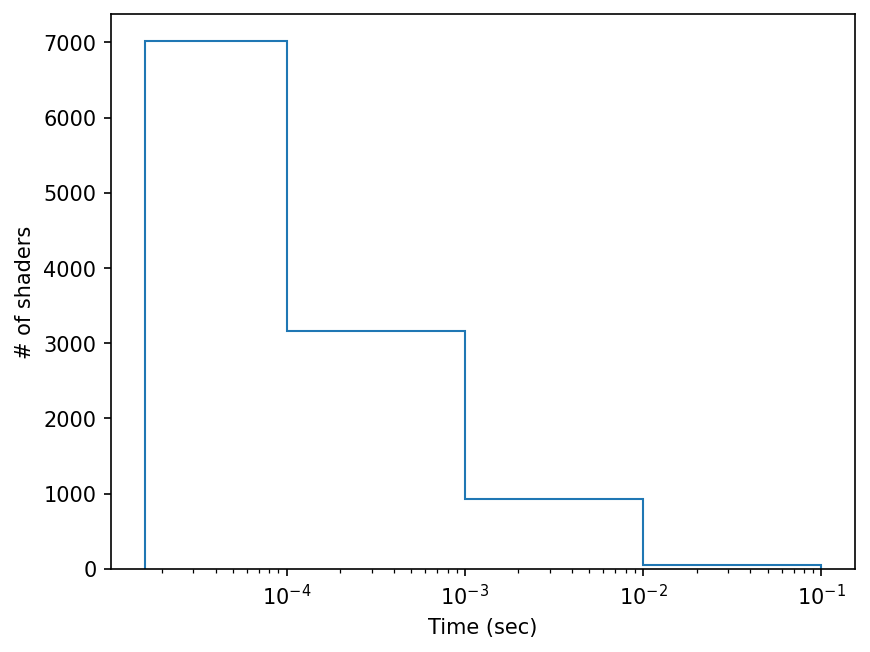

In [14]:
separationPoint = [np.min(timeMean), 1e-4, 1e-3, 1e-2, np.max(timeMean)]
print(separationPoint)
hist, binEdges = np.histogram(timeMean, bins=separationPoint)

fig, ax = plt.subplots()
ax.stairs(hist, binEdges)
ax.set_xscale('log')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('# of shaders')
plt.show()

#### Normalized time comparison

- Mean-Stdev Normalizer
- LogPlusNormalizer

Normalizer name 'Normalizer', mean=-2.0348458514697698e-17, stdev=0.9999552522653317
First 10 values: [-0.14883534 -0.14876721 -0.1487555  -0.14875231 -0.14871612 -0.14871612
 -0.14871292 -0.1487076  -0.1486895  -0.14859902];
Last 10 values: [20.40413659 20.81867363 21.2243935  21.51559869 24.05935604 24.1013108
 26.62696435 27.59316929 28.33580569 31.01008659]


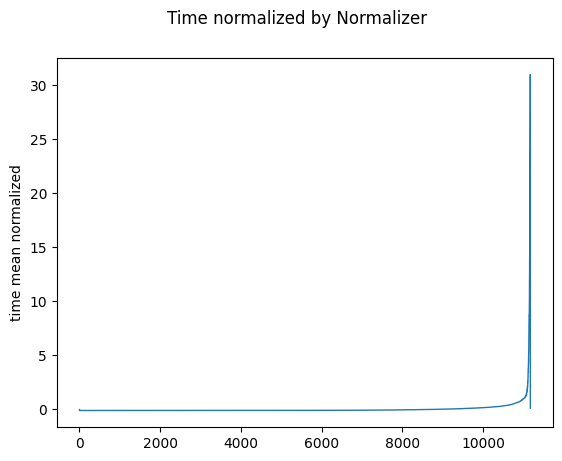

NOTE: No need to build from samples for LogPlusNormalizer
Normalizer name 'LogPlusNormalizer', mean=0.0004882280759406475, stdev=0.0031097286724440275
First 10 values: [1.60357114e-05 1.62541612e-05 1.62917073e-05 1.63019471e-05
 1.64179986e-05 1.64179986e-05 1.64282384e-05 1.64453048e-05
 1.65033305e-05 1.67934590e-05];
Last 10 values: [0.06383828 0.06508453 0.06630277 0.06717625 0.07477404 0.07489887
 0.08238498 0.08523408 0.08741843 0.09524512]


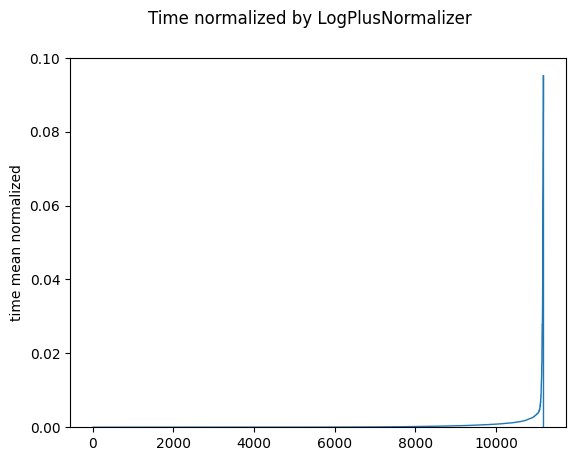

NOTE: No need to build from samples for LogNormalizer
Normalizer name 'LogNormalizer', mean=-9.450486605935593, stdev=1.616037337514306
First 10 values: [-11.04068434 -11.02715348 -11.02484619 -11.02421785 -11.01712414
 -11.01712414 -11.01650064 -11.01546232 -11.0119401  -10.9945127 ];
Last 10 values: [-2.71931329 -2.6993496  -2.68018903 -2.66665939 -2.55566451 -2.55393328
 -2.45487689 -2.4194342  -2.39302155 -2.30330102]


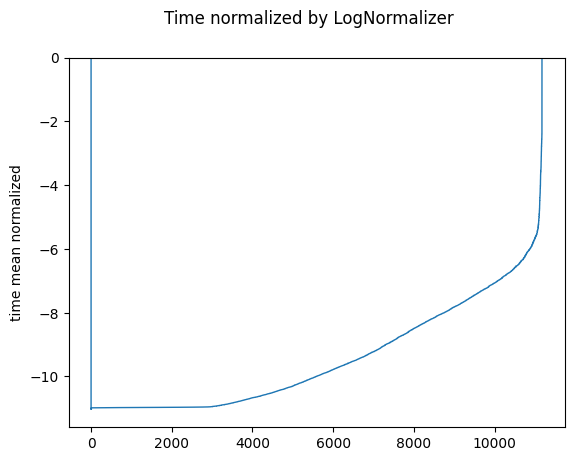

In [15]:
from misc.normalization import Normalizer, LogPlusNormalizer, LogNormalizer

def sampleIterator():
    numSamples = len(timeMean)
    for i in range(0, numSamples):
        yield timeMean[i]

# Mean-stdev normalizer
for normalizerCls in (Normalizer, LogPlusNormalizer, LogNormalizer):
    if hasattr(normalizerCls, 'buildFromSamples'):
        normalizer = normalizerCls.buildFromSamples(sampleIterator())
    else:
        print(f"NOTE: No need to build from samples for {normalizerCls.__name__}")
        normalizer = normalizerCls()
    normalizedMean = normalizer.normalize(timeMean)
    print(f"Normalizer name '{normalizerCls.__name__}', mean={np.mean(normalizedMean)}, stdev={np.std(normalizedMean)}")

    print(f"First 10 values: {normalizedMean[:10]};\nLast 10 values: {normalizedMean[-10:]}")

    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.suptitle(f"Time normalized by {normalizerCls.__name__}")

    ax.stairs(normalizedMean)

    # ax1.set_xlabel('Ordinal by timeMean')
    ax.set_ylabel('time mean normalized')
    # ax.set_yscale('log')
    plt.show()


> Stair graph's first segment comes from (0, 0), so the graph itself is ok.

In [16]:
print(f"original time statistics: mean={np.mean(timeMean)} std={np.std(timeMean)}") 

original time statistics: mean=0.0004932826283491438 std=0.0032063986737895876


### Distribution of basic block trace count

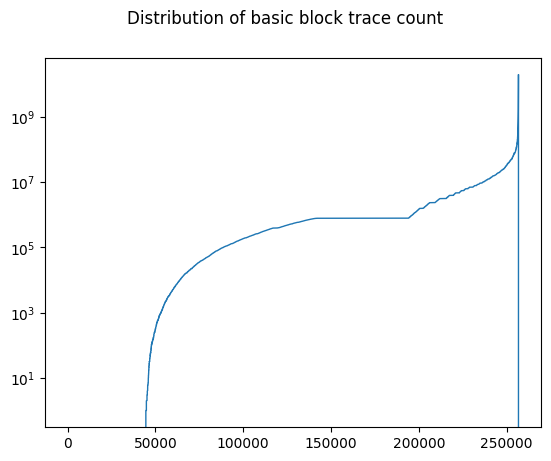

In [17]:
bbTraceCounts = []

for shaderId, expr in shader_to_experiment.items():
  bbTraceCounters = json.loads(expr.trace.bb_trace_counters)
  bbTraceCounts += bbTraceCounters

bbTraceCounts = np.array(bbTraceCounts, dtype=np.uint64)
bbTraceCounts = np.sort(bbTraceCounts)

fig, ax = plt.subplots()
fig.suptitle('Distribution of basic block trace count')

ax.stairs(bbTraceCounts)
ax.set_yscale('log')

plt.show()

In [18]:
print(f"Maximum value: {np.max(bbTraceCounts):.10e}")

Maximum value: 2.0132659200e+10


#### Test for normalizer impact on trace count

Normalizer name 'Normalizer', mean=3.543218959245647e-18, stdev=0.9999980520928801
First 10 values: [-0.04026484 -0.04026484 -0.04026484 -0.04026484 -0.04026484 -0.04026484
 -0.04026484 -0.04026484 -0.04026484 -0.04026484];
Last 10 values: [106.8666208  106.8666208  106.8666208  110.20746097 110.20746097
 110.20746097 120.23165348 120.23165348 120.23165348 120.70330806]


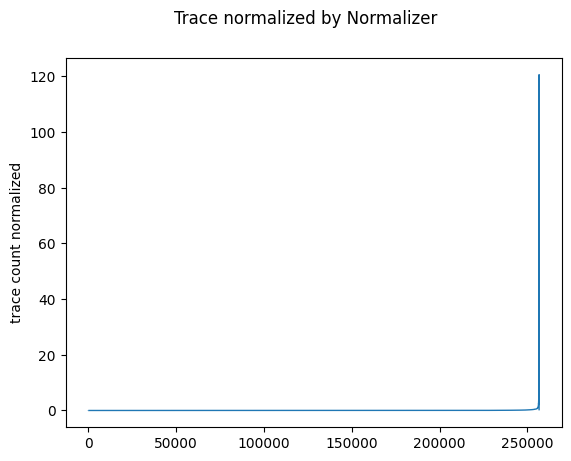

NOTE: No need to build from samples for LogPlusNormalizer
Normalizer name 'LogPlusNormalizer', mean=10.734879161966985, stdev=5.5274478599213746
First 10 values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.];
Last 10 values: [23.60389833 23.60389833 23.60389833 23.63466999 23.63466999 23.63466999
 23.72169527 23.72169527 23.72169527 23.72560917]


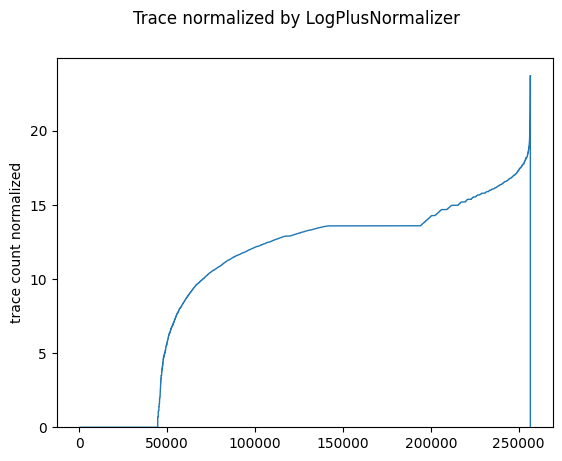

NOTE: No need to build from samples for LogNormalizer
Normalizer name 'LogNormalizer', mean=-inf, stdev=nan
First 10 values: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf];
Last 10 values: [23.60389833 23.60389833 23.60389833 23.63466999 23.63466999 23.63466999
 23.72169527 23.72169527 23.72169527 23.72560917]


/home/libreliu/Projects/NGPP/vkPredict/notebooks/../misc/normalization.py:95: RuntimeWarning: divide by zero encountered in log
  return np.log(sample)
/home/libreliu/Projects/NGPP/vkPredict/venv/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


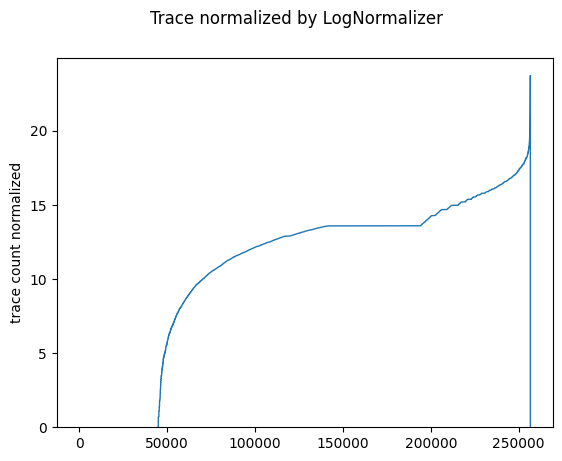

In [19]:
def sampleIterator():
    numSamples = len(bbTraceCounts)
    for i in range(0, numSamples):
        yield bbTraceCounts[i]

# Mean-stdev normalizer
for normalizerCls in (Normalizer, LogPlusNormalizer, LogNormalizer):
    if hasattr(normalizerCls, 'buildFromSamples'):
        normalizer = normalizerCls.buildFromSamples(sampleIterator())
    else:
        print(f"NOTE: No need to build from samples for {normalizerCls.__name__}")
        normalizer = normalizerCls()
    normalizedTraceCount = normalizer.normalize(bbTraceCounts)
    print(f"Normalizer name '{normalizerCls.__name__}', mean={np.mean(normalizedTraceCount)}, stdev={np.std(normalizedTraceCount)}")

    print(f"First 10 values: {normalizedTraceCount[:10]};\nLast 10 values: {normalizedTraceCount[-10:]}")

    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.suptitle(f"Trace normalized by {normalizerCls.__name__}")

    ax.stairs(normalizedTraceCount)

    # ax1.set_xlabel('Ordinal by timeMean')
    ax.set_ylabel('trace count normalized')
    # ax.set_yscale('log')
    plt.show()

Test for occurance count on using binary encoding

In [20]:
def do_onehot_base2(trace_labels_raw: torch.Tensor, d_embed: int, shifted=False) -> 'torch.Tensor':
    bsz, seq_len = trace_labels_raw.size()
    trace_labels = trace_labels_raw.to(dtype=torch.int64, device=trace_labels_raw.device)
    ones = torch.ones((d_embed,), dtype=torch.int64, device=trace_labels.device)

    # (d_embed, )
    masks = torch.bitwise_left_shift(ones, torch.arange(d_embed, device=trace_labels.device))
    trace_embeds = (torch.bitwise_and(trace_labels.view(bsz, seq_len, 1), masks.view(1, 1, d_embed)) > 0).float()
    if shifted:
        trace_embeds -= 0.5

    return trace_embeds

trace_labels = torch.as_tensor(bbTraceCounts.astype(dtype=np.int64)).unsqueeze(0)
print(trace_labels.size())

trace_embeds = do_onehot_base2(trace_labels, 64).squeeze()
print(trace_embeds.size())

summed = torch.sum(trace_embeds, dim=0, dtype=torch.int64)
print(summed.size())
print(summed)

print(torch.sum((summed > 0).int()))
print(torch.nonzero(summed)[-1])

torch.Size([1, 256686])
torch.Size([256686, 64])
torch.Size([64])
tensor([ 49840,  55559,  59023,  60980,  58940,  60280,  61010,  61096,  62888,
         61919,  64063,  62947,  62132,  60895,  58153,  57415,  55248,  52430,
        100580,  96781,  32386,  32312,  23086,  15561,   8670,   4661,   2223,
           734,    248,    213,     91,     53,     18,     13,     10,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(35)
tensor([34])


所以，看起来可以测试测试 `` 选择 37，33，30 下的表现

## Token related

The output dictionary for HfSpvTokenizer contains:
- `input_ids`
- `trace_labels`

...and other encoded keys for padding purpose

Note that we use a configuration equivalent to `HfTracedSpvTokenizer-multiple-entrypoint`.

Also, validate every tokenized shader begins with `[BOS]`.

In [21]:
from misc.HfTracedSpvTokenizer import HfTracedSpvTokenizer

tokenizer = HfTracedSpvTokenizer(
  single_entrypoint=False,
  compact_types=False,
  convert_ext_insts=False  
)

shaderTokenizedLength = []
exhaustiveIDSpaceShaderIds = []
for idx, (shaderId, expr) in tqdm(enumerate(shader_to_experiment.items())):
  try:
    tokenized = tokenizer(
      spvBinaryRepr=expr.shader.fragment_spv,
      id2TraceIdxMap={int(k): v for k, v in json.loads(expr.trace.bb_idx_map).items()},
      traceCounters=json.loads(expr.trace.bb_trace_counters)
    )

    if tokenized["input_ids"][0] != tokenizer.get_command("[BOS]"):
      raise Exception("[BOS] not present in the beginning of the tokenized shader")

    shaderTokenizedLength.append(len(tokenized["input_ids"]))
  except RuntimeError as e:
    if "Id exceed max available length" in e.__str__():
      exhaustiveIDSpaceShaderIds.append(shaderId)
    else:
      raise

shaderTokenizedLength = np.array(shaderTokenizedLength)
print(f"Successfully tokenized: {len(shaderTokenizedLength)}")
print(f"Failed to tokenize because of exhaustive ID space usage: {exhaustiveIDSpaceShaderIds}")

11174it [00:52, 210.97it/s]

Successfully tokenized: 11085
Failed to tokenize because of exhaustive ID space usage: ['3djyz1', '3dyBzw', '3syXWc', '3tKGDW', '4dtSDs', '4ll3RS', '4sSXWt', '4sV3zR', '4tV3RW', '7dj3Dc', '7dtXDs', '7lGyDV', '7lKyDV', '7s2GR3', 'DdXSWj', 'MlSSDR', 'MldGWS', 'MlyGWh', 'MsV3WW', 'MtGBRW', 'Mtf3zM', 'NdX3Wj', 'NdjBDV', 'NlGfRy', 'NllBDS', 'NsV3zW', 'NscSzB', 'NstGDM', 'Nt2fzc', 'NtjXW1', 'Wd3Gz4', 'WdGyDw', 'WdKSRc', 'Ws3yRs', 'WsBXWR', 'WsGXWm', 'WtKfWw', 'WtcfWS', 'WtjyWV', 'XdcyRf', 'XdtGRr', 'XlBfRR', 'XlVXDz', 'XlXcRX', 'XllSWf', 'XsVyRw', 'Xsl3DS', 'XtSyRD', 'XtfBz4', 'dssXzB', 'dttGRM', 'fd3XRS', 'fdK3DD', 'fl2yzG', 'fl3fWS', 'flcGDB', 'fltXD8', 'fssSz2', 'fstXz8', 'ft2XWw', 'ftdSWM', 'ftffDf', 'ld3Gzs', 'ldKBRm', 'ldtXRS', 'll2BzR', 'll3cRB', 'lsG3zt', 'lsdGRs', 'lt3SW8', 'ltjGD1', 'ltlXRS', 'lty3zc', 'mt23z3', 'sd33WS', 'sltGRf', 'sltXWX', 'sscGz4', 'ssd3Rr', 'stdyRH', 'tdSBzc', 'tdjSDw', 'tdsyzB', 'tlSSzc', 'wdlGz7', 'wljSDh', 'wllczN', 'ws3yRB', 'wtcXRs']


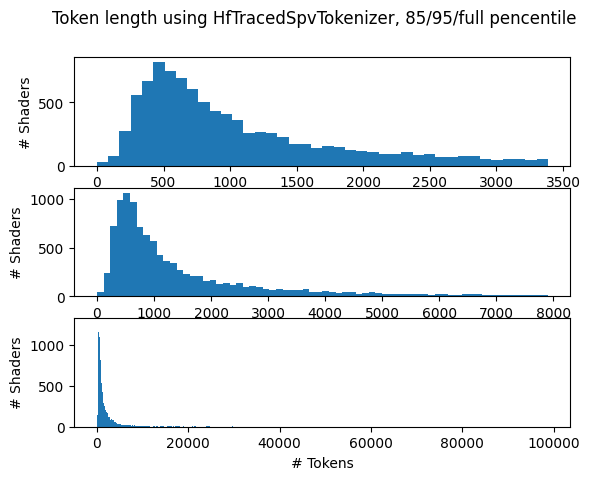

In [22]:
plt.rcParams['figure.dpi'] = 100
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle(f"Token length using {tokenizer.__class__.__name__}, 85/95/full pencentile")
    
max_85 = np.percentile(shaderTokenizedLength, 85)
max_95 = np.percentile(shaderTokenizedLength, 95)
ax1.hist(shaderTokenizedLength, bins='auto', range=(0, max_85))
# ax1.set_xlabel('# SPIR-V instructions')
ax1.set_ylabel('# Shaders')
    
ax2.hist(shaderTokenizedLength, bins='auto', range=(0, max_95))
ax2.set_xlabel("# Tokens")
ax2.set_ylabel('# Shaders')

ax3.hist(shaderTokenizedLength, bins='auto')
ax3.set_xlabel("# Tokens")
ax3.set_ylabel('# Shaders')

plt.show()

In [23]:
print(f"Percentiles:")
for cutPoint in [95, 90, 85, 80, 75]:
  print(f"- {cutPoint}%: {np.percentile(shaderTokenizedLength, cutPoint)}")

Percentiles:
- 95%: 7901.199999999997
- 90%: 4686.0
- 85%: 3386.5999999999985
- 80%: 2610.4000000000015
- 75%: 2102.0


Test for the cut point we chose

In [24]:
for cutPoint in [1024, 4096]:
  count = np.sum(shaderTokenizedLength <= cutPoint)
  print(f"- <={cutPoint}: {count} ({count / len(shaderTokenizedLength) * 100}% of the original)")

- <=1024: 5855 (52.8191249436175% of the original)
- <=4096: 9782 (88.24537663509247% of the original)


### TODO: Test for type and ExtInst compaction